In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import PIL
%matplotlib inline

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = "/home/tyler/data/image/kids/"

kids_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])
dataset_loader = torch.utils.data.DataLoader(kids_dataset,
                                             batch_size=8, shuffle=True,
                                             num_workers=8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
n_class = len(kids_dataset.classes)
model_ft = models.vgg19_bn(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
features = list(model_ft.classifier.children())[:-1]
features.extend([nn.Linear(num_ftrs, n_class)])
model_ft.classifier = nn.Sequential(*features)


ct = 0
for name, child in model_ft.named_children():
    ct += 1
    if ct < 2:
        for name2, params in child.named_parameters():
            params.requires_grad = False

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)

In [5]:
num_epochs = 5
losses = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    model_ft.train() 


    # Iterate over data.
    for inputs, labels in dataset_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        losses.append(loss)

        # backward + optimize only if in training phase
        loss.backward()
        optimizer.step()
    print(loss.item())

Epoch 0/4
----------
0.9691853523254395
Epoch 1/4
----------
0.15172253549098969
Epoch 2/4
----------
0.2765083312988281
Epoch 3/4
----------
0.11616287380456924
Epoch 4/4
----------
0.1485762745141983


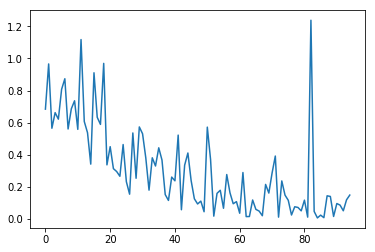

In [6]:
plt.plot(losses)

In [49]:
test_image = PIL.Image.open("/home/tyler/Downloads/aiden3.jpg")

In [50]:
trn_image = data_transforms['val'](test_image)
trn_image = trn_image.unsqueeze(0).to(device)

In [51]:
model_ft.eval()
kids_dataset.classes[torch.argmax(model_ft(trn_image)).item()]

'aiden'

In [52]:
model_ft(trn_image)

tensor([[ 3.0217, -1.7910]], grad_fn=<AddmmBackward>)

In [53]:
kids_dataset.classes

['aiden', 'other']

## Save for Production

In [54]:
torch.save(model_ft, "./models/kids.pkl")